In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime as dt
from pandas import Series, DataFrame

style.use('ggplot')
%matplotlib inline

First, we need to establish a start and end time for our query. After establishing the start and end time, the data can be quried. 

In [24]:
start = dt.datetime(1990, 1, 1)
end = dt.datetime(2018, 5, 30)
pep_raw = web.DataReader("PEP", 'morningstar', start, end)

In [25]:
pep_raw.head()

Close    High     Low    Open   Volume
Symbol Date                                               
PEP    1990-01-01  9.8039  9.8039  9.6699  9.8039        0
       1990-01-02  9.8423  9.8423  9.6316  9.8423  3468979
       1990-01-03  9.7465  9.8997  9.7274  9.7465  3722918
       1990-01-04  9.6507  9.7082  9.4975  9.6507  2993740
       1990-01-05  9.5167  9.6507  9.4401  9.5167  3759475

In [26]:
pep_raw.tail()

Close     High     Low    Open   Volume
Symbol Date                                                
PEP    2018-05-24  100.18  100.580   99.76  100.31  4664307
       2018-05-25  100.31  101.110   99.90  100.18  5324275
       2018-05-28  100.31  100.310  100.31  100.31        0
       2018-05-29  101.10  101.285  100.00  100.00  8302569
       2018-05-30  101.83  102.240  101.09  101.66  6246348

We need to reset the index to "Date" and then drop the "Symbol" column 

In [87]:
pep_raw.reset_index(inplace=True)
pep_raw.set_index("Date", inplace=True)
pep_raw = pep_raw.drop("Symbol", axis=1)

In [88]:
pep_raw.head()

,Close,High,Low,Open,Volume
Date,,,,,
1990-01-01,9.8039,9.8039,9.6699,9.8039,0
1990-01-02,9.8423,9.8423,9.6316,9.8423,3468979
1990-01-03,9.7465,9.8997,9.7274,9.7465,3722918
1990-01-04,9.6507,9.7082,9.4975,9.6507,2993740
1990-01-05,9.5167,9.6507,9.4401,9.5167,3759475


In [89]:
pep_raw.to_csv('PEP.csv')

In [9]:
pep = pd.read_csv('PEP.csv', parse_dates=True, index_col=0)

In [10]:
pep.head()

,Close,High,Low,Open,Volume
Date,,,,,
1990-01-01,9.8039,9.8039,9.6699,9.8039,0
1990-01-02,9.8423,9.8423,9.6316,9.8423,3468979
1990-01-03,9.7465,9.8997,9.7274,9.7465,3722918
1990-01-04,9.6507,9.7082,9.4975,9.6507,2993740
1990-01-05,9.5167,9.6507,9.4401,9.5167,3759475


Now that we have the data, lets see how this looks when we plot it

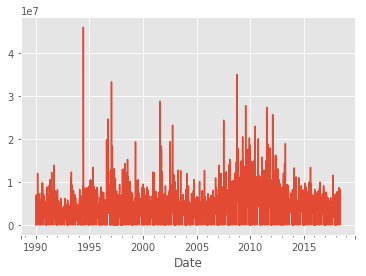

In [11]:
pep['Volume'].plot()
plt.rcParams["figure.figsize"] = (30,10)
plt.show()

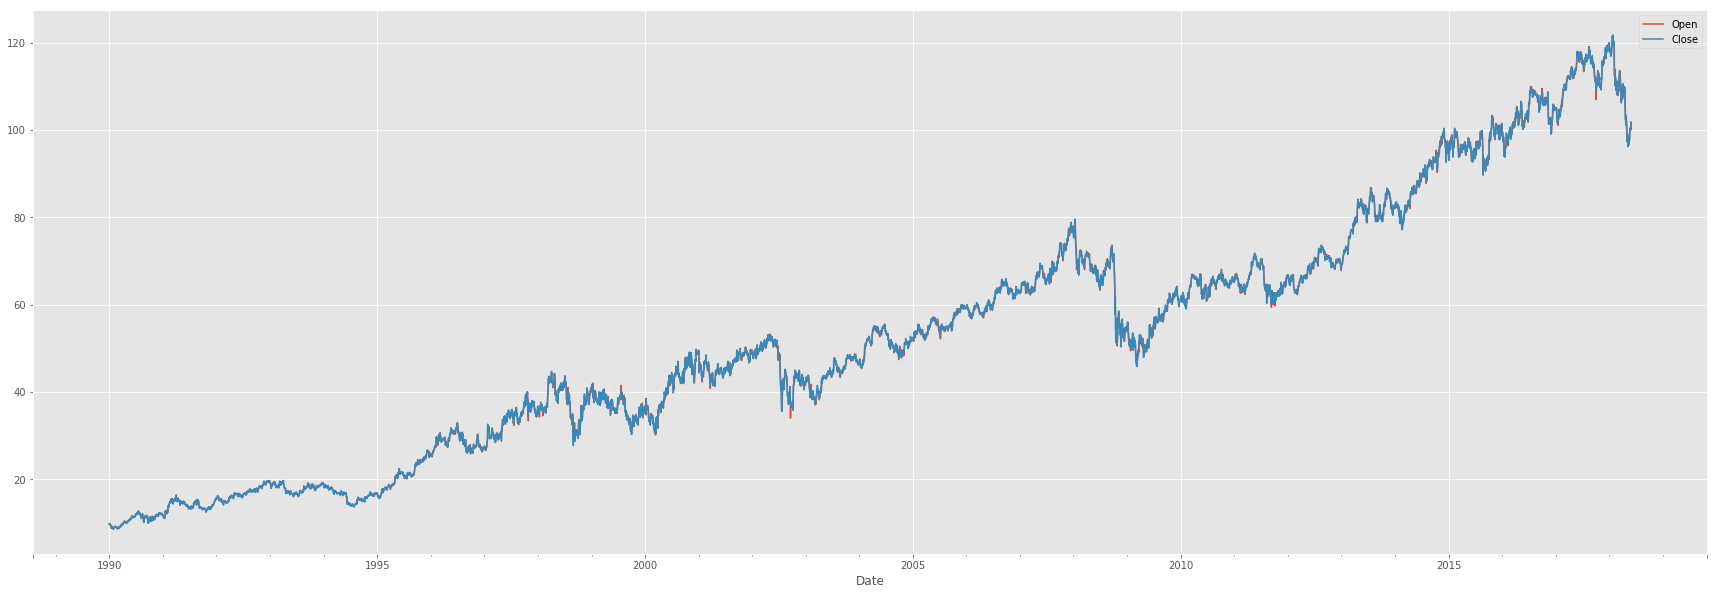

In [93]:
pep[['Open','Close']].plot()
plt.rcParams["figure.figsize"] = (30,10)
plt.show()

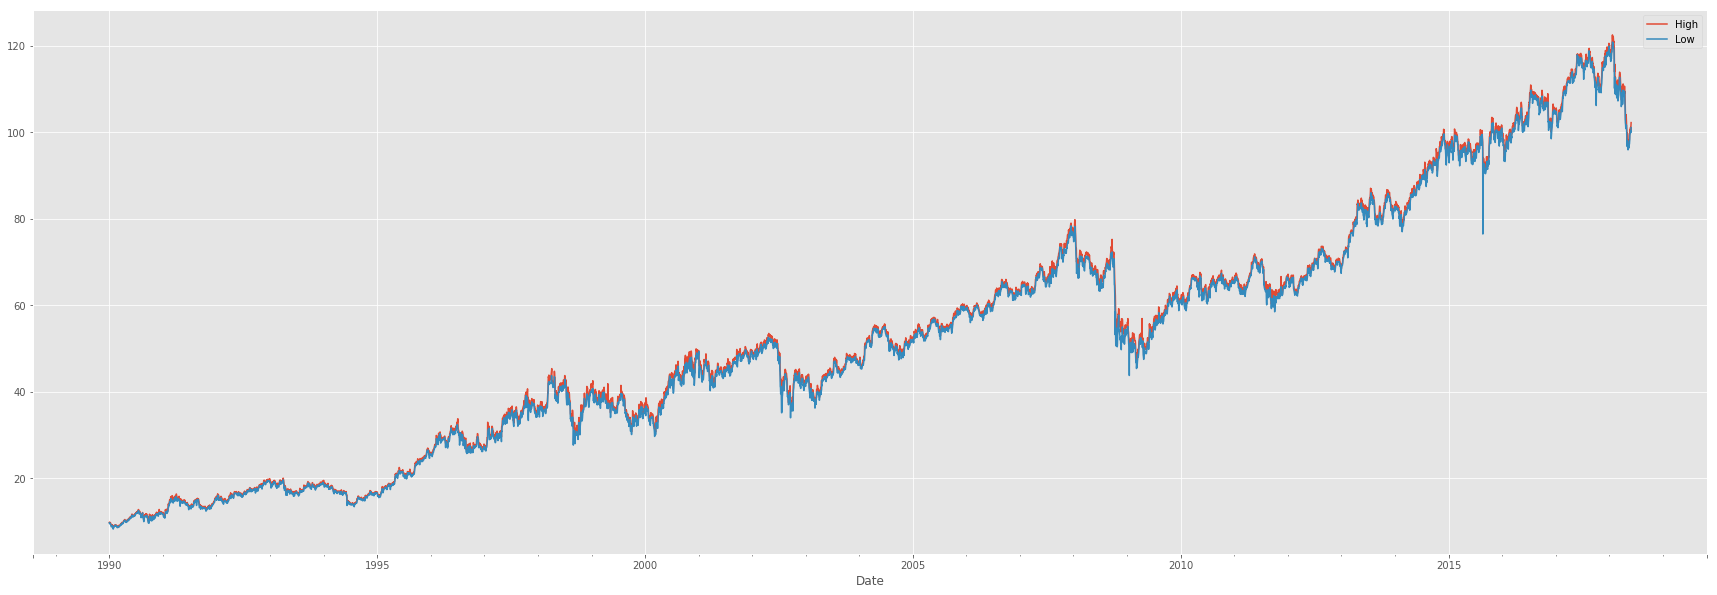

In [94]:
pep[['High', 'Low']].plot()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

A simple moving average is to take a window of time, and calculate the average price in that window of time. Then we shift that window over one period, and do it again. We'll do a 100 day rolling moving average

In [95]:
pep['100days'] = pep['Close'].rolling(window=100,min_periods=0).mean()

In [96]:
pep.head()

,Close,High,Low,Open,Volume,100days
Date,,,,,,
1990-01-01,9.8039,9.8039,9.6699,9.8039,0,9.803900
1990-01-02,9.8423,9.8423,9.6316,9.8423,3468979,9.823100
1990-01-03,9.7465,9.8997,9.7274,9.7465,3722918,9.797567
1990-01-04,9.6507,9.7082,9.4975,9.6507,2993740,9.760850
1990-01-05,9.5167,9.6507,9.4401,9.5167,3759475,9.712020


We will graph the close and the 100ma on the first axis, and the volume on the 2nd axis


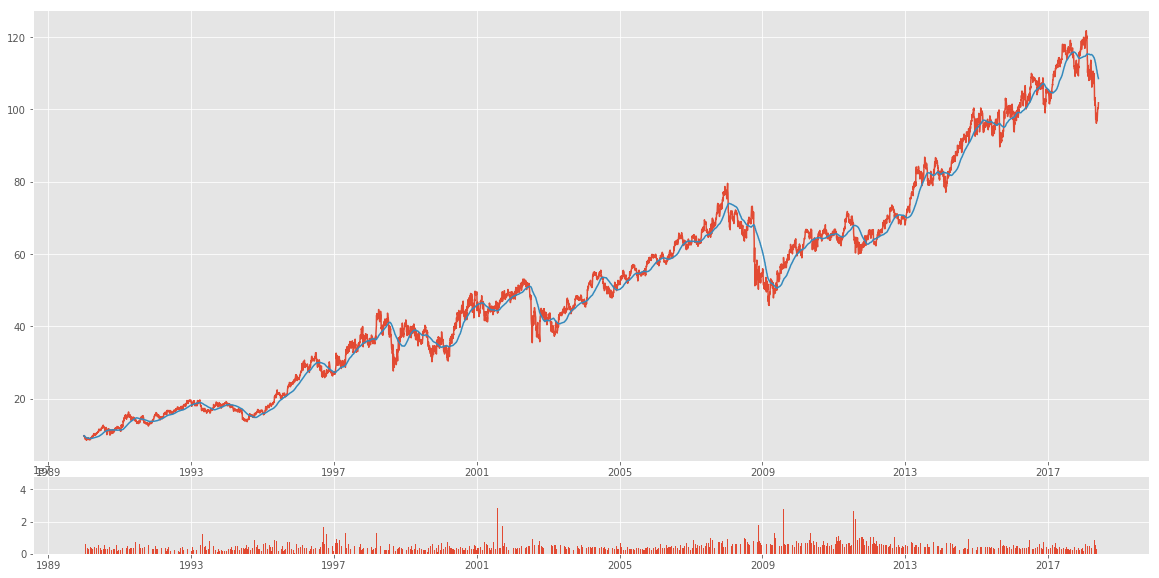

In [97]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot(pep.index, pep['Close'])
ax1.plot(pep.index, pep['100days'])
ax2.bar(pep.index, pep['Volume'])

plt.show()

 plot the cumulative returns of each stock

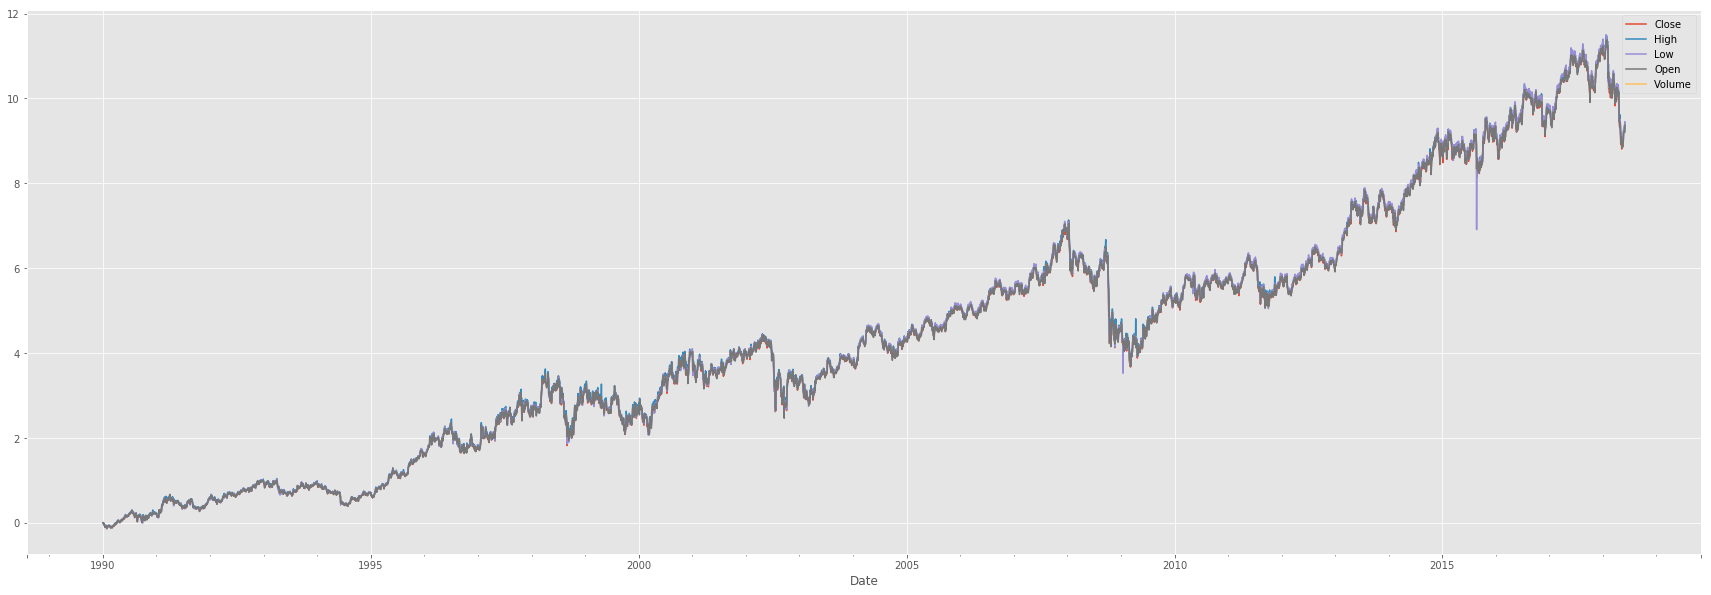

In [5]:
plt.rcParams["figure.figsize"] = (30,10)
pep = pep.asfreq('B').fillna(method='pad')
rets = pep.pct_change()
((1 + rets).cumprod() - 1).plot()

Compute momentum over a certain lookback, then rank in descending order and standardize

### Future Contract Rolling

In [12]:
pep_close = pep['Close']

In [13]:
pep_close.head()

Date
1990-01-01    9.8039
1990-01-02    9.8423
1990-01-03    9.7465
1990-01-04    9.6507
1990-01-05    9.5167
Name: Close, dtype: float64

In [14]:
expiry = {'ESU2': dt.datetime(2018, 9, 21),
          'ESZ2': dt.datetime(2018, 12, 21)}

expiry = Series(expiry).sort_values()

In [15]:
expiry

ESU2   2018-09-21
ESZ2   2018-12-21
dtype: datetime64[ns]

We use finance prices along with a random walk and some noise to simulate the two contracts into the future. A seed of 111111 is used to initialize the random number generator. The random number generator allows the results to be duplicated later. N is a variable that will be used to establish the desired number of simulated data points.

In [16]:
np.random.seed(111111)

In [17]:
N = 200

The distance for each random walk step is calculated by generating an array of 200 random integers between 0 and 200, subtracting 100 and multiplying by 0.25, ((0, 200, size=N) - 100)(0.25)). These numbers are stored in the array called walk. The noise for each step is calculated by generating 200 random integers between 0 and 20, subtracting 10 and multiplying by 0.25, (0, 20, size=N) - 10)(0.25)). These numbers are stored in the array called perturb. Finally, the array walk is then converted into a cumulative sum. 

In [18]:
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

Inorder to encapsulate the dates from the historical data abd the additional 200 simulated dates, we need to create a date range. This daterange is stored in rng. Note that this range is only for weekdays.


In [19]:
rng = pd.date_range(pep_close.index[0], periods=len(pep_close) + N, freq='B')

Now we can create two timeseries, the near contrant and the far contract. First we create the near contract. This is created by adding the cumulative walk values to the last element in the pep_close time series. Secondly, we create the far contract. the far contract is created by adding the cumulative walk values, the random noise generated in the perturb time series and the last element in the pep_close time series. These two contracts are then used to create a prices dataframe. 



In [20]:
near = np.concatenate([pep_close.values, pep_close.values[-1] + walk])
far = np.concatenate([pep_close.values, pep_close.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

We want to know how this new dataframe looks with the two contracts. 

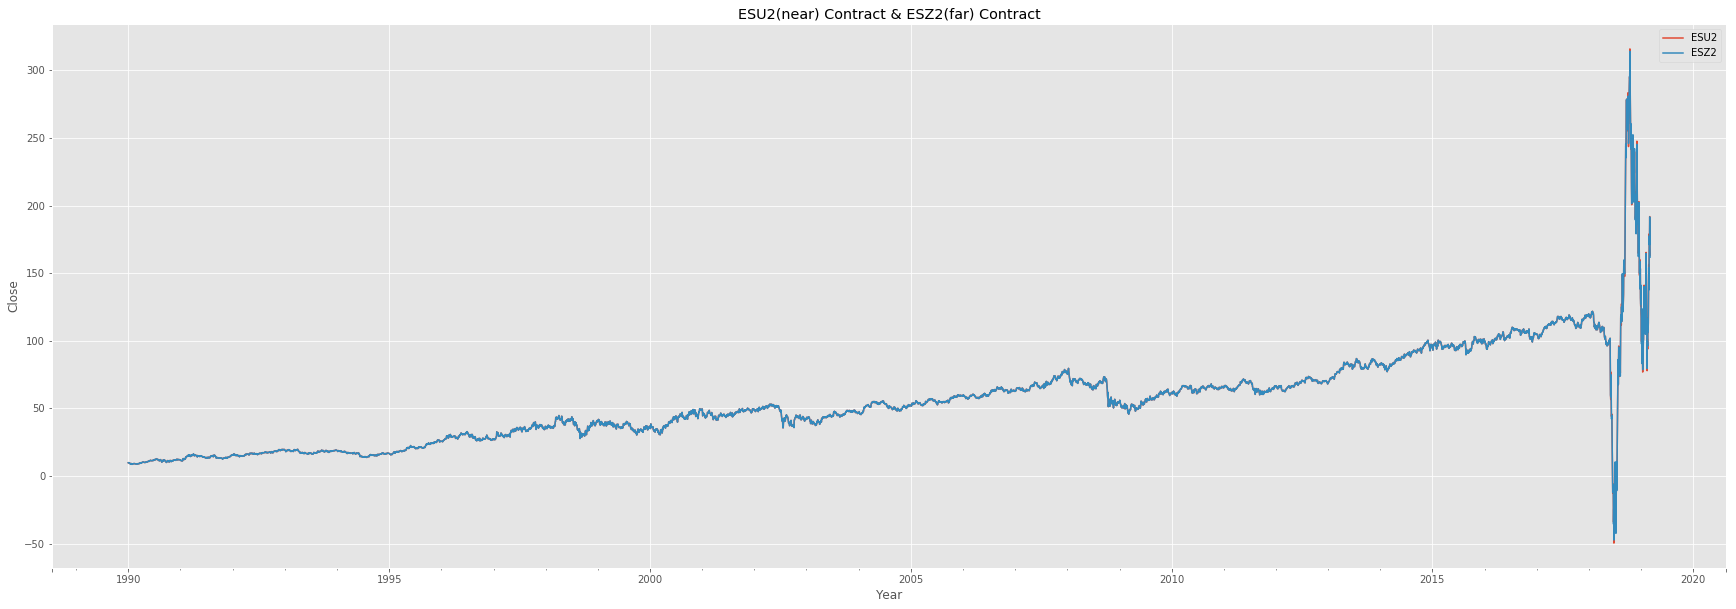

In [21]:
prices.plot()
plt.title("ESU2(near) Contract & ESZ2(far) Contract")
plt.xlabel("Year")
plt.ylabel("Close")
plt.show()

One way to splice time series together into a single continuous series is to construct a
weighting matrix. Active contracts would have a weight of 1 until the expiry date approaches.
At that point you have to decide on a roll convention. Here is a function that
computes a weighting matrix with linear decay over a number of periods leading up to
expiry

In [22]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names
    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
    index=dates, columns=items)
    prev_date = weights.index[0]
    
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.loc[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
            periods=roll_periods + 1, freq='B')
            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.loc[roll_rng, item] = 1 - decay_weights
            weights.loc[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.loc[prev_date:, item] = 1
            
        prev_date = ex_date
        
    return weights

In [27]:
weights = get_roll_weights('5/1/2018', expiry, prices.columns)

In [30]:
weights.loc['2018-09-12':'2018-09-21']

,ESU2,ESZ2
2018-09-12,1.0,0.0
2018-09-13,1.0,0.0
2018-09-14,0.8,0.2
2018-09-17,0.6,0.4
2018-09-18,0.4,0.6
2018-09-19,0.2,0.8
2018-09-20,0.0,1.0
2018-09-21,0.0,1.0


In [33]:
rolled_returns = (prices.pct_change() * weights).sum(1)

In [34]:
rolled_returns['2018-05-01':].mean()

-0.11374752911446881

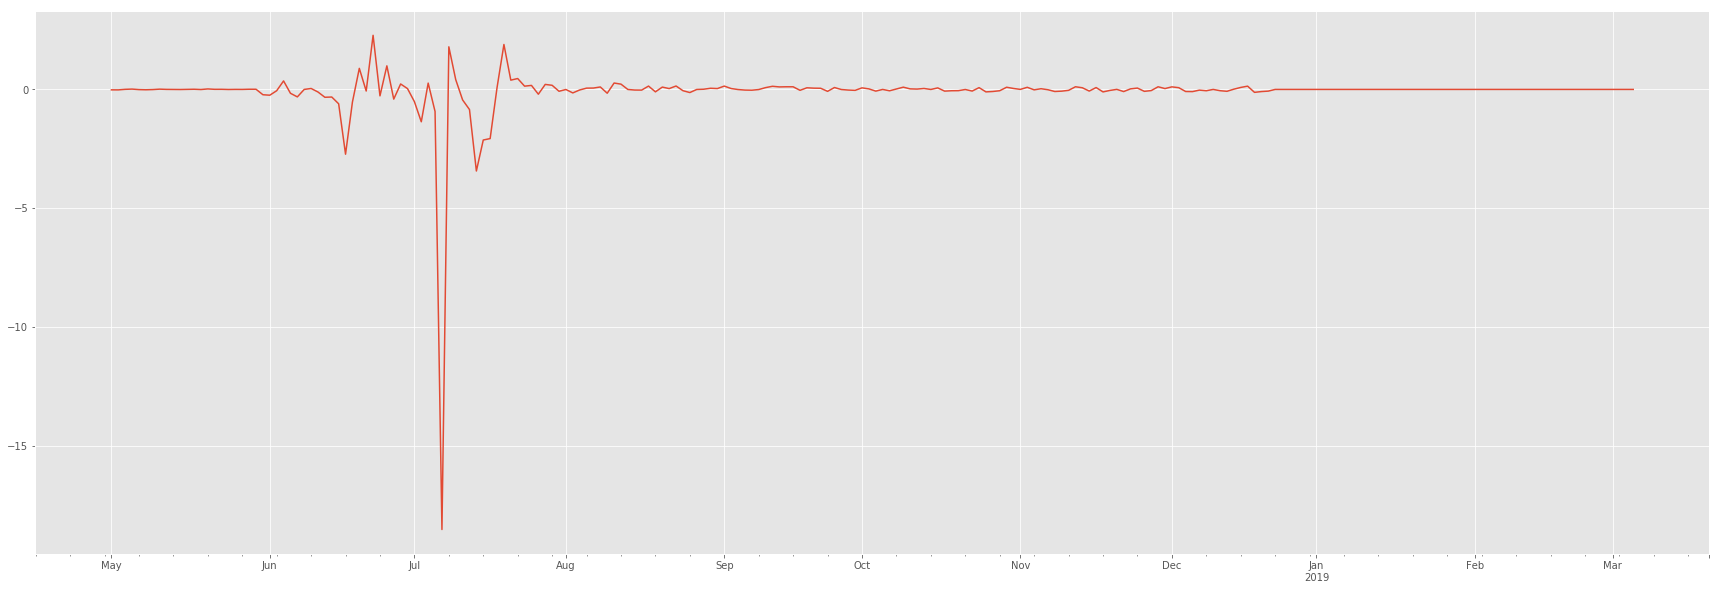

In [36]:
rolled_returns['2018-05-01':].plot()

### Rolling correlation for each stock

In [85]:
ge_raw = web.DataReader("GE", 'morningstar', start, end)
ge_raw.reset_index(inplace=True)
ge_raw.set_index("Date", inplace=True)
ge_raw = ge_raw.drop("Symbol", axis=1)
ge_close = ge_raw['Close']

In [91]:
ibm_raw = web.DataReader("IBM", 'morningstar', start, end)
ibm_raw.reset_index(inplace=True)
ibm_raw.set_index("Date", inplace=True)
ibm_raw = ibm_raw.drop("Symbol", axis=1)
ibm_close = ibm_raw['Close']

Grab the percent change for each stock

In [92]:
pep_rets = pep_close.pct_change()
ge_rets = ge_close.pct_change()
ibm_rets = ibm_close.pct_change()

Plot the correlation for Pepsi and GE

/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<Series>)
  after removing the cwd from sys.path.


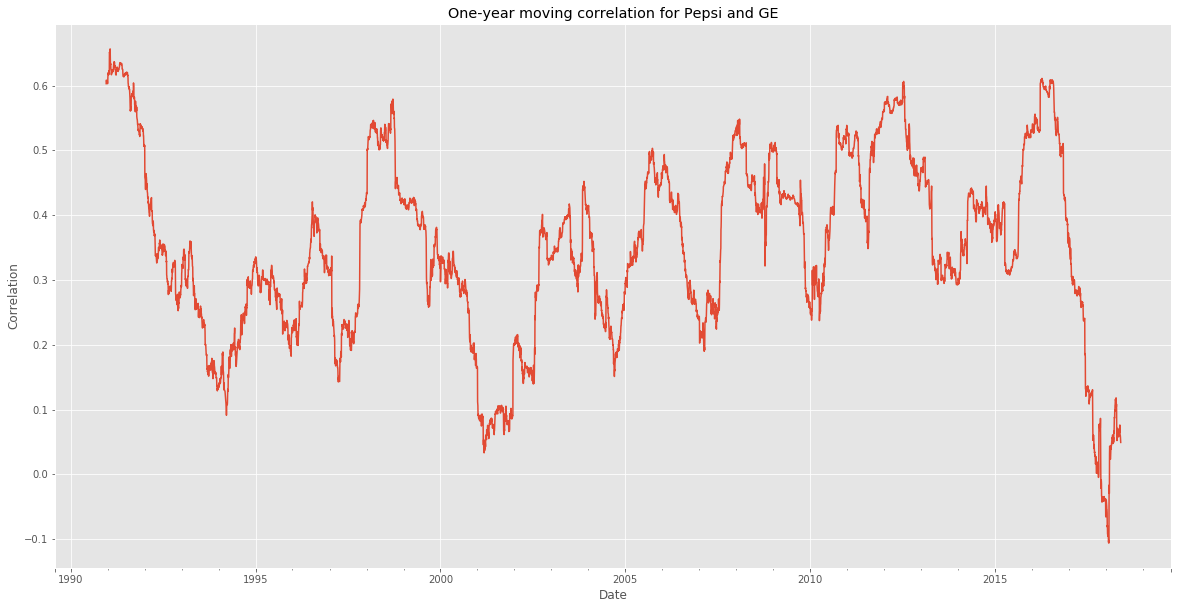

In [101]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("One-year moving correlation for Pepsi and GE")
plt.ylabel("Correlation")
pd.rolling_corr(pep_rets, ge_rets, 250).plot()

/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<Series>)
  after removing the cwd from sys.path.


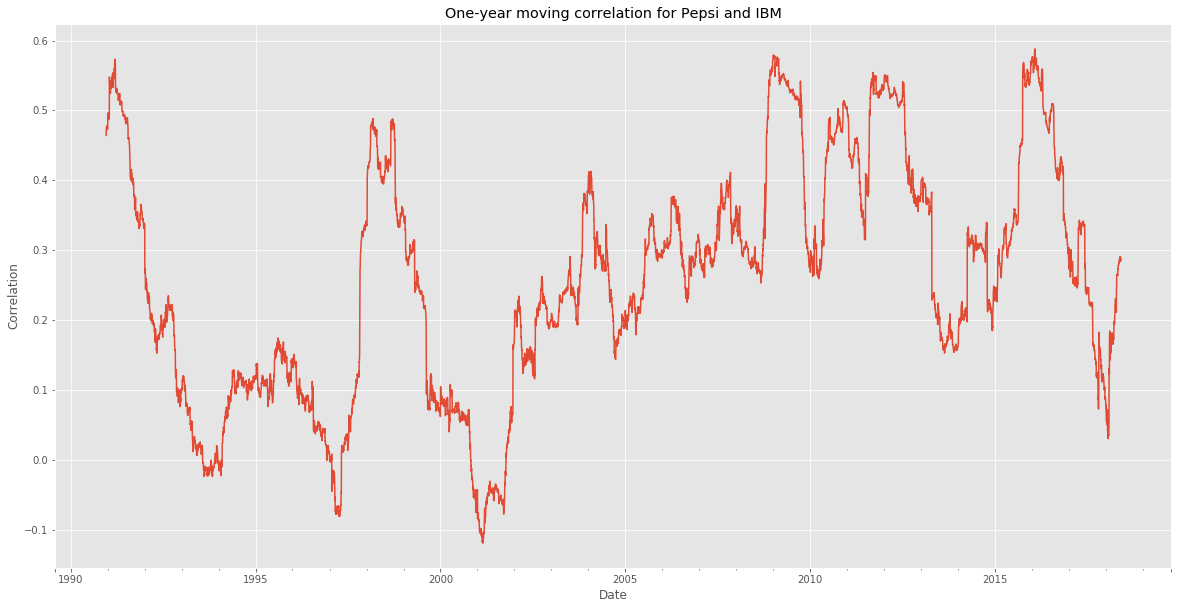

In [96]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("One-year moving correlation for Pepsi and IBM")
plt.ylabel("Correlation")
pd.rolling_corr(pep_rets, ibm_rets, 250).plot()

/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<Series>)
  after removing the cwd from sys.path.


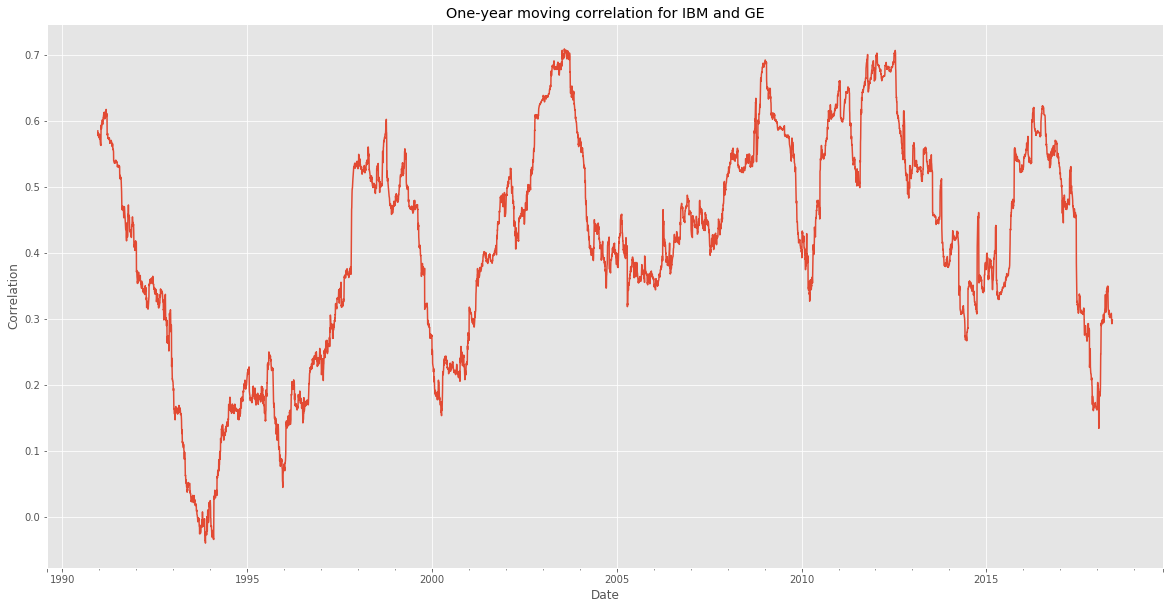

In [97]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("One-year moving correlation for IBM and GE")
plt.ylabel("Correlation")
pd.rolling_corr(ibm_rets, ge_rets, 250).plot()